# Moment Applied to Clustered Price Data (Each Entry)
Due to the Minimum sequence length requirement of 512, we either needed to pad the data to use monthly values, or use each entry. we opted to use each entry.

In [47]:
import pandas as pd
# Constants
#!pip install numpy pandas matplotlib tqdm
#!pip install git+https://github.com/moment-timeseries-foundation-model/moment.git
FORECAST_HORIZON = 24
SEQ_LEN = 512
BATCH_SIZE = 10
MAX_EPOCH = 10
DATASET_PATH = '../[3.1] - OUTLIER_REMOVAL/zone_data_1A_clustered.csv'

# Sort the data by date column
data.sort_values(by='date', inplace=True)
# Resample the data to 3-day intervals and sort


data['date'] = pd.to_datetime(data['Application Creation Date'])
data.set_index('date', inplace=True)
data = data.resample('3D').mean().dropna()
data.sort_index(inplace=True)



# Load the dataset
data = pd.read_csv(DATASET_PATH)
print("Data loaded successfully.")
print(data)




Data loaded successfully.
        Status Application Creation Date Approved / Refused Date  \
0     Recorded                2013-12-07              24/07/2013   
1     Recorded                2018-04-13              26/04/2018   
2     Recorded                2011-02-09              05/09/2011   
3     Recorded                2017-06-21              26/06/2017   
4     Recorded                2017-06-19              23/06/2017   
...        ...                       ...                     ...   
9688  Recorded                2023-08-28              06/09/2023   
9689  Recorded                2012-12-21              24/12/2012   
9690  Recorded                2020-01-09              08/09/2020   
9691  Recorded                2020-01-15              17/02/2020   
9692  Recorded                2020-10-12              12/01/2021   

     Recorded / Rejected Date Water Share ID Water System Source Reliability  \
0                  23/08/2013      WEE****24            Goulburn        High 

In [48]:
from momentfm import MOMENTPipeline
from torch.nn.functional import pad


#Initialise the model.
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", 
    model_kwargs={
        #can load in (1) reconstruction, (2) embedding, (3) forecasting, and (4) classification tasks
        'task_name': 'forecasting',

        # Number of steps to forecast (original is 192)
        'forecast_horizon': FORECAST_HORIZON,

        #???
        'head_dropout': 0.1,

        #???
        'weight_decay': 0,
        'freeze_encoder': True, # Freeze the patch embedding layer
        'freeze_embedder': True, # Freeze the transformer encoder
        'freeze_head': False, # The linear forecasting head must be trained
    },
)
model.init()




In [49]:

print("Patch Length:", model.patch_len)

# Parameters that need to be trained
print("Unfrozen parameters:")
for name, param in model.named_parameters():    
    if param.requires_grad:
        print('    ', name)

Patch Length: 8
Unfrozen parameters:
     head.linear.weight
     head.linear.bias


In [50]:
# Do a "forward pass through moment", and then examine output. MOMENT model needs 3 inputs:
# 1. An input timeseries of 512(change later??) timesteps
# 2. Two "optional" masks, both of length 512
# "The input mask is utilized to regulate the time steps or patches that the model should attend to. For instance, in the case of shorter time series, you may opt not to attend to padding. To implement this, you can provide an input mask with zeros in the padded locations."
#"The second mask, referred to simply as mask, denotes masked or unobserved values. We employ mask tokens to replace all patches containing any masked time step (for further details, refer to Section 3.2 in our paper). MOMENT can attend to these mask tokens during reconstruction."

from pprint import pprint
import torch

# takes in tensor of shape [batchsize, n_channels, context_length]
x = torch.randn(BATCH_SIZE, 1, SEQ_LEN)
output = model(x)

#model return "TimeseriesOutputs" Object
pprint(output)

TimeseriesOutputs(forecast=tensor([[[-1.1764e-01, -5.2511e-02,  9.5951e-02,  3.2528e-02, -1.7622e-02,
           4.1567e-02,  3.2528e-02, -5.3972e-02, -4.3377e-02,  1.2147e-01,
           1.4247e-01,  8.5782e-02, -4.3524e-02,  1.3901e-02,  8.5385e-02,
          -1.6103e-02,  9.1851e-02,  5.1122e-02, -5.3892e-02,  7.5732e-02,
           3.2528e-02,  1.4867e-01,  2.1983e-02, -1.3213e-02]],

        [[-9.3733e-02, -7.1698e-02, -1.6030e-02, -5.3313e-02, -2.1251e-02,
           7.4585e-02, -3.4510e-02,  2.5126e-02, -7.1718e-02,  2.5761e-03,
           1.1035e-01,  8.0054e-02, -1.9646e-02,  1.0340e-01,  2.3656e-02,
          -1.3158e-02,  1.8884e-02,  1.1372e-01,  2.3656e-02, -3.5771e-02,
           3.6916e-02,  2.3656e-02, -5.9851e-02, -5.8731e-02]],

        [[-3.4059e-02, -8.1746e-02,  4.1962e-03,  4.1962e-03, -5.8078e-02,
           4.1962e-03, -2.2720e-02, -2.5392e-01,  4.1962e-03,  4.1962e-03,
           1.9815e-01,  5.6896e-02,  2.1569e-02, -6.3960e-02,  7.5315e-02,
           1.7646e

In [51]:
from typing import Optional

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


class MyInformerDataset:
    def __init__(
        self,
        forecast_horizon: Optional[int] = FORECAST_HORIZON,
        data_split: str = "train",
        data_stride_len: int = 2,
        task_name: str = "forecasting",
        random_seed: int = 42,
    ):
        """
        Parameters
        ----------
        forecast_horizon : int
            Length of the prediction sequence.
        data_split : str
            Split of the dataset, 'train' or 'test'.
        data_stride_len : int
            Stride length when generating consecutive
            time series windows.
        task_name : str
            The task that the dataset is used for. One of
            'forecasting', or  'imputation'.
        random_seed : int
            Random seed for reproducibility.
        """

        self.seq_len = SEQ_LEN
        self.forecast_horizon = forecast_horizon
        self.full_file_path_and_name = DATASET_PATH
        self.data_split = data_split
        self.data_stride_len = data_stride_len
        self.task_name = task_name
        self.random_seed = random_seed

        # Read data
        self._read_data()

    def _get_borders(self):
        n_train = int(0.7 * self.length_timeseries_original)  # 70% for training
        n_val = int(0.15 * self.length_timeseries_original)   # 15% for validation
        n_test = self.length_timeseries_original - n_train - n_val  # Remaining for test


        train_end = n_train
        val_end = n_train + n_val
        test_start = val_end - self.seq_len
        test_end = test_start + n_test + self.seq_len

        train = slice(0, train_end)
        test = slice(test_start, test_end)

        return train, test

    def _read_data(self):
        self.scaler = StandardScaler()
        df = pd.read_csv(self.full_file_path_and_name)
        self.length_timeseries_original = df.shape[0]
        self.n_channels = df.shape[1] - 1

        df.drop(columns=["Application Creation Date"], inplace=True)
        df = df[['Volume Traded (ML)', 'Price Per ML ($)']]
        #modify to remove copy
        df = df.infer_objects().interpolate(method="cubic")

        data_splits = self._get_borders()

        train_data = df[data_splits[0]]
        self.scaler.fit(train_data.values)
        df = self.scaler.transform(df.values)

        if self.data_split == "train":
            self.data = df[data_splits[0], :]
        elif self.data_split == "test":
            self.data = df[data_splits[1], :]

        self.length_timeseries = self.data.shape[0]

    def __getitem__(self, index):
        seq_start = self.data_stride_len * index
        seq_end = seq_start + self.seq_len
        input_mask = np.ones(self.seq_len)

        if self.task_name == "forecasting":
            pred_end = seq_end + self.forecast_horizon

            if pred_end > self.length_timeseries:
                pred_end = self.length_timeseries
                seq_end = seq_end - self.forecast_horizon
                seq_start = seq_end - self.seq_len

            timeseries = self.data[seq_start:seq_end, :].T
            forecast = self.data[seq_end:pred_end, :].T

            return timeseries, forecast, input_mask

        elif self.task_name == "imputation":
            if seq_end > self.length_timeseries:
                seq_end = self.length_timeseries
                seq_end = seq_end - self.seq_len

            timeseries = self.data[seq_start:seq_end, :].T

            return timeseries, input_mask

    def __len__(self):
        if self.task_name == "imputation":
            return (self.length_timeseries - self.seq_len) // self.data_stride_len + 1
        elif self.task_name == "forecasting":
            return (self.length_timeseries - self.seq_len - self.forecast_horizon) // self.data_stride_len + 1

## Model FineTuning
"The forecasting head is randomly initialized, so it must be trained on your data."


In [52]:
import numpy as np
import pandas as pd
import torch
import torch.cuda.amp
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

from momentfm.utils.utils import control_randomness
#from momentfm.data.informer_dataset import InformerDataset
from momentfm.utils.forecasting_metrics import get_forecasting_metrics

# Set random seeds for PyTorch, Numpy etc.
control_randomness(seed=13) 

# Load data
# Specify the path to your CSV file
#csv_file_path = '../data/ETTh1.csv'
df = pd.read_csv(DATASET_PATH)
#df = pd.read_csv(DATASET_PATH, usecols=[2, 3])  # Indexing starts from 0, so 3 and 4 are at indices 2 and 3
#df = df.drop(columns=["date"])
print(df)
print(len(df))

train_size = int(0.8 * len(df))
print(train_size)
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:-(SEQ_LEN+FORECAST_HORIZON)]

train_dataset = MyInformerDataset(data_split="train", random_seed=13, forecast_horizon=FORECAST_HORIZON)
test_dataset = MyInformerDataset(data_split="test", random_seed=13, forecast_horizon=FORECAST_HORIZON)
#train_dataset = ETThDataset(df_train, forecast_horizon=FORECAST_HORIZON)
#test_dataset = ETThDataset(df_test, forecast_horizon=FORECAST_HORIZON)


# doesn't Affects running time much! (64 default) but less makes it speed up epochs to match data loading
batch_size = BATCH_SIZE
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cur_epoch = 0
max_epoch = MAX_EPOCH

# Move the model to the GPU
model = model.to(device)

# Move the loss function to the GPU
criterion = criterion.to(device)

# Enable mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Create a OneCycleLR scheduler
max_lr = 1e-4
total_steps = len(train_loader) * max_epoch
scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.3)

# Gradient clipping value
max_norm = 5.0

while cur_epoch < max_epoch:
    losses = []
    for timeseries, forecast, input_mask in tqdm(train_loader, total=len(train_loader)):
        # Move the data to the GPU
        timeseries = timeseries.float().to(device)
        input_mask = input_mask.to(device)
        forecast = forecast.float().to(device)

        with torch.cuda.amp.autocast():
            print(timeseries.shape)
            output = model(timeseries, input_mask)
        
        loss = criterion(output.forecast, forecast)

        # Scales the loss for mixed precision training
        scaler.scale(loss).backward()

        # Clip gradients
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        losses.append(loss.item())

    losses = np.array(losses)
    average_loss = np.average(losses)
    print(f"Epoch {cur_epoch}: Train loss: {average_loss:.3f}")

    # Step the learning rate scheduler
    scheduler.step()
    cur_epoch += 1
    
    # Evaluate the model on the test split
    trues, preds, histories, losses, dates = [], [], [], [], []
    model.eval()
    with torch.no_grad():
        for timeseries, forecast, input_mask in tqdm(test_loader):
        # Move the data to the GPU
            timeseries = timeseries.float().to(device)
            input_mask = input_mask.to(device)
            forecast = forecast.float().to(device)

            with torch.cuda.amp.autocast():
                print(timeseries.shape)
                output = model(timeseries, input_mask)
            
            loss = criterion(output.forecast, forecast)                
            losses.append(loss.item())

            trues.append(forecast.detach().cpu().numpy())
            preds.append(output.forecast.detach().cpu().numpy())
            histories.append(timeseries.detach().cpu().numpy())
    dates.append(date_ticks)
    
    losses = np.array(losses)
    average_loss = np.average(losses)
    model.train()

    trues = np.concatenate(trues, axis=0)
    preds = np.concatenate(preds, axis=0)
    histories = np.concatenate(histories, axis=0)
    
    metrics = get_forecasting_metrics(y=trues, y_hat=preds, reduction='mean')

    print(f"Epoch {cur_epoch}: Test MSE: {metrics.mse:.3f} | Test MAE: {metrics.mae:.3f}")

        Status Application Creation Date Approved / Refused Date  \
0     Recorded                2013-12-07              24/07/2013   
1     Recorded                2018-04-13              26/04/2018   
2     Recorded                2011-02-09              05/09/2011   
3     Recorded                2017-06-21              26/06/2017   
4     Recorded                2017-06-19              23/06/2017   
...        ...                       ...                     ...   
9688  Recorded                2023-08-28              06/09/2023   
9689  Recorded                2012-12-21              24/12/2012   
9690  Recorded                2020-01-09              08/09/2020   
9691  Recorded                2020-01-15              17/02/2020   
9692  Recorded                2020-10-12              12/01/2021   

     Recorded / Rejected Date Water Share ID Water System Source Reliability  \
0                  23/08/2013      WEE****24            Goulburn        High   
1                  01/0

/opt/homebrew/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
  0%|          | 0/313 [00:00<?, ?it/s]/opt/homebrew/lib/python3.11/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


torch.Size([10, 2, 512])


  0%|          | 1/313 [00:02<11:15,  2.17s/it]

torch.Size([10, 2, 512])


  1%|          | 2/313 [00:03<09:21,  1.81s/it]

torch.Size([10, 2, 512])


  1%|          | 3/313 [00:05<08:34,  1.66s/it]

torch.Size([10, 2, 512])


  1%|▏         | 4/313 [00:06<08:10,  1.59s/it]

torch.Size([10, 2, 512])


  2%|▏         | 5/313 [00:08<07:57,  1.55s/it]

torch.Size([10, 2, 512])


  2%|▏         | 6/313 [00:09<07:39,  1.50s/it]

torch.Size([10, 2, 512])


  2%|▏         | 7/313 [00:10<07:27,  1.46s/it]

torch.Size([10, 2, 512])


  3%|▎         | 8/313 [00:12<07:17,  1.44s/it]

torch.Size([10, 2, 512])


  3%|▎         | 9/313 [00:13<07:13,  1.43s/it]

torch.Size([10, 2, 512])


  3%|▎         | 10/313 [00:15<07:09,  1.42s/it]

torch.Size([10, 2, 512])


  3%|▎         | 10/313 [00:16<08:24,  1.67s/it]


KeyboardInterrupt: 

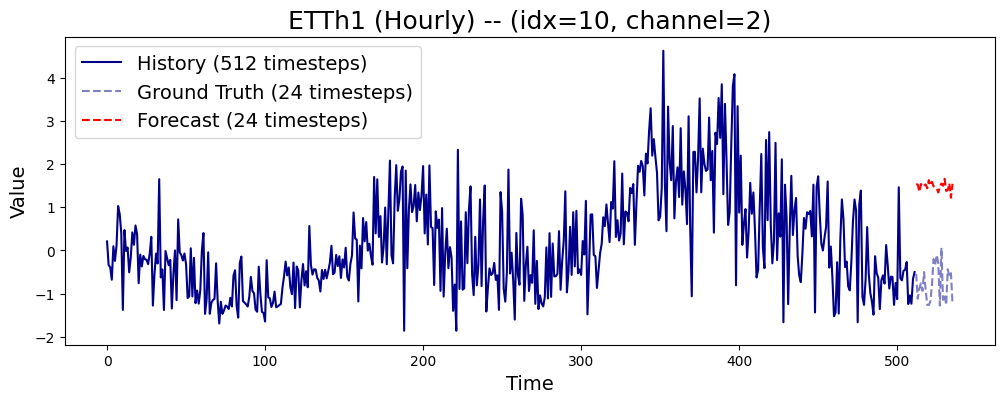

In [ ]:
# visualise it!

import matplotlib.pyplot as plt

# Assuming histories, trues, and preds are your lists containing the data
# Extracting the first data point

channel_idx = np.random.randint(0, trues.shape[1]) # There are 7 channels in this dataset
time_index = np.random.randint(0, trues.shape[0]) 

history = histories[time_index, channel_idx, :] 
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]
date_ticks = dates[time_index:time_index + len(history) + len(true)]  # Adjust this according to your date data

plt.figure(figsize=(12, 4))

# Plotting the first time series from history
plt.plot(date_ticks[:len(history)], history, label='History (512 timesteps)', c='darkblue')

# Plotting ground truth and prediction
plt.plot(date_ticks[len(history):len(history) + len(true)], true, label=f'Ground Truth ({len(true)} timesteps)', color='darkblue', linestyle='--', alpha=0.5)
plt.plot(date_ticks[len(history):len(history) + len(pred)], pred, label=f'Forecast ({len(pred)} timesteps)', color='red', linestyle='--')

plt.title(f"Zone Data 1A Clustered -- (idx={time_index}, channel={channel_idx})", fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=14)
plt.gcf().autofmt_xdate()  # Rotate date labels to fit them better
plt.show()

# Calculate R^2 (Coefficient of Determination)
ss_res = np.sum((trues - preds) ** 2)
ss_tot = np.sum((trues - np.mean(trues)) ** 2)
r2_score = 1 - (ss_res / ss_tot)

# Create a DataFrame to display the metrics
metrics_data = {
    'Metric': ['MSE', 'MAE', 'R^2'],
    'Value': [metrics.mse, metrics.mae, r2_score]
}

metrics_df = pd.DataFrame(metrics_data)


import pandas as pd

# Calculate R^2 (Coefficient of Determination)
ss_res = np.sum((trues - preds) ** 2)
ss_tot = np.sum((trues - np.mean(trues)) ** 2)
r2_score = 1 - (ss_res / ss_tot)

# Create a DataFrame to display the metrics
metrics_data = {
    'Metric': ['MSE', 'MAE', 'R^2'],
    'Value': [metrics.mse, metrics.mae, r2_score]
}

metrics_df = pd.DataFrame(metrics_data)


# Display the DataFrame as a table
print(metrics_df.to_string(index=False))

